In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release-20160523/bin'
#PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
#PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = '/scratch/SuperResolution/BRAINSSuperResolution/HCPWorkflows/:/scratch/wmql/tract_querier/tract_querier/nipype/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

In [3]:
output_dir = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask'

In [4]:
inputT1 = '/Shared/sinapse/CACHE/20160610_HCP_base_Results/HCP_DATA/105115/HCP_105115_01/TissueClassify/t1_average_BRAINSABC.nii.gz'
inputT2 = '/Shared/sinapse/CACHE/20160610_HCP_base_Results/HCP_DATA/105115/HCP_105115_01/TissueClassify/t2_average_BRAINSABC.nii.gz'
DWI_baseline = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/SuperResolution/DWI_Baseline.nrrd'
LobesLabelMapVolume = '/Shared/sinapse/CACHE/20160610_HCP_base_Results/HCP_DATA/105115/HCP_105115_01/JointFusion/JointFusion_HDAtlas20_2015_lobe_label.nii.gz'
DWI_brainMask = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/DWIBrainMask.nrrd'

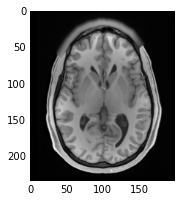

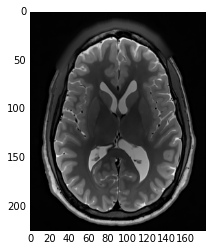

In [5]:
t1 = sitk.ReadImage(inputT1)
t2 = sitk.ReadImage(inputT2)
myshow(t1)
myshow(t2)

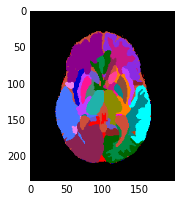

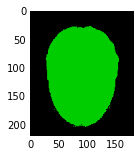

In [6]:
lobeLabels = sitk.ReadImage(LobesLabelMapVolume)
myshow(sitk.LabelToRGB(lobeLabels))

dwiBrainMask = sitk.ReadImage(DWI_brainMask)
myshow(sitk.LabelToRGB(dwiBrainMask))

In [7]:
print(t1.GetSize())
print(t2.GetSize())
print(lobeLabels.GetSize())
print(dwiBrainMask.GetSize())

(198, 232, 188)
(256, 320, 320)
(198, 232, 188)
(145, 174, 145)


In [8]:
orig_dwi = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/DWI_corrected_alignedSpace_masked.nrrd'
# Create IDWI image
DTIEstim = dtiestim()
DTIEstim.inputs.method = 'wls'
DTIEstim.inputs.threshold = 0
#DTIEstim.inputs.correctionType = 'nearest'
DTIEstim.inputs.tensor_output = os.path.join(output_dir,'DTI_Output.nrrd')
DTIEstim.inputs.idwi = os.path.join(output_dir,'IDWI_Output.nrrd')
DTIEstim.inputs.B0 = os.path.join(output_dir,'average_B0.nrrd')
DTIEstim.inputs.dwi_image = orig_dwi #DWI_baseline #orig_dwi
DTIEstim.inputs.brain_mask = DWI_brainMask
print(DTIEstim.cmdline)
DTIEstim.run()

 dtiestim  --B0 /scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask/average_B0.nrrd --brain_mask /scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/DWIBrainMask.nrrd --dwi_image /scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs/DWI_corrected_alignedSpace_masked.nrrd --idwi /scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask/IDWI_Output.nrrd --method wls --tensor_output /scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask/DTI_Output.nrrd --threshold 0


(145, 174, 145)
(1.2500000000000002, 1.25, 1.25)


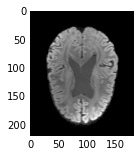

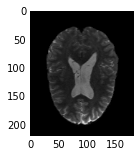

In [18]:
idwi = sitk.ReadImage(DTIEstim.inputs.idwi)
myshow(idwi)

avgB0 = sitk.ReadImage(DTIEstim.inputs.B0)
myshow(avgB0)

print(avgB0.GetSize())
print(avgB0.GetSpacing())

(72, 87, 72)
(2.5000000000000004, 2.5, 2.5)


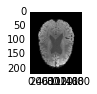

In [34]:
#avgB0_lr = sitk.Shrink(avgB0,[2,2,2])
avgB0_lr = sitk.Shrink(idwi,[2,2,2])
myshow(avgB0_lr)
avgB0_lr_fn = os.path.join(output_dir,'AvgB0LowRes.nrrd')
sitk.WriteImage(avgB0_lr,avgB0_lr_fn)

print(avgB0_lr.GetSize())
print(avgB0_lr.GetSpacing())

In [35]:
PurePlugsMaskNode = GeneratePurePlugMask()
PurePlugsMaskNode.inputs.threshold = 0.2
PurePlugsMaskNode.inputs.outputMaskFile = os.path.join(output_dir,'PurePlugsMask.nrrd')
#PurePlugsMaskNode.inputs.inputImageModalities = [inputT1, inputT2, DTIEstim.inputs.B0]
PurePlugsMaskNode.inputs.inputImageModalities = [DTIEstim.inputs.B0, avgB0_lr_fn]
print(PurePlugsMaskNode.cmdline)
PurePlugsMaskNode.run()

 GeneratePurePlugMask  --inputImageModalities /scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask/average_B0.nrrd --inputImageModalities /scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask/AvgB0LowRes.nrrd --outputMaskFile /scratch/TESTS/IpythonNotebook/20160615_HCPWF/PurePlugsMask/PurePlugsMask.nrrd --threshold 0.200000


In [36]:
purePlugsMask_fn = os.path.join(output_dir,'PurePlugsMask.nrrd')

(72, 87, 72)
(2.5000000000000004, 2.5, 2.5)


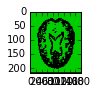

In [37]:
ppmask = sitk.ReadImage(purePlugsMask_fn)
myshow(sitk.LabelToRGB(ppmask))
print(ppmask.GetSize())
print(ppmask.GetSpacing())

(145, 174, 145)
(1.2500000000000002, 1.25, 1.25)


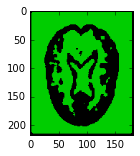

In [38]:
# resample ppmask to dwiBrainMask
def ResampleMask(in_mask, ref_mask):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_mask)
    resampler.SetInterpolator(sitk.sitkLabelGaussian) # Smoothly interpolate multi-label images
    res_mask = resampler.Execute(in_mask)
    return res_mask

ppmask = ResampleMask(ppmask, dwiBrainMask)
myshow(sitk.LabelToRGB(ppmask))
print(ppmask.GetSize())
print(ppmask.GetSpacing())

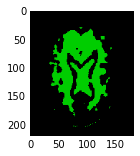

In [39]:
ppmask = ppmask * sitk.Cast(dwiBrainMask,sitk.sitkUInt8)
sitk.WriteImage(ppmask,os.path.join(output_dir,'BrainPurePlugsMask.nrrd'))
myshow(sitk.LabelToRGB(ppmask))

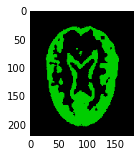

In [40]:
notppmask = 1-ppmask
notppmask = notppmask * sitk.Cast(dwiBrainMask,sitk.sitkUInt8)
myshow(sitk.LabelToRGB(notppmask))

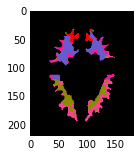

In [41]:
# resample input label map to lattice space of pure plug mask (DWI mask)
lobeLabels = ResampleMask(lobeLabels, ppmask)
## define lobe labels
temporal_wm = ((lobeLabels == 9703) + (lobeLabels == 9803))
occipital_wm = ((lobeLabels == 9706) + (lobeLabels == 9806))
frontal_wm = ((lobeLabels == 9707) + (lobeLabels == 9807))
parietal_wm = ((lobeLabels == 9708) + (lobeLabels == 9808))
## define pure/ not pure labels
temporal_wm_pure = temporal_wm * ppmask
temporal_wm_NOTpure = temporal_wm * (1 - ppmask)
#
occipital_wm_pure = occipital_wm * ppmask
occipital_wm_NOTpure = occipital_wm * (1 - ppmask)
#
frontal_wm_pure = frontal_wm * ppmask
frontal_wm_NOTpure = frontal_wm * (1 - ppmask)
#
parietal_wm_pure = parietal_wm * ppmask
parietal_wm_NOTpure = parietal_wm * (1 - ppmask)
## all above masks should have no overlap, so test it!
wholemask = (temporal_wm_pure + temporal_wm_NOTpure
             + occipital_wm_pure + occipital_wm_NOTpure
             + frontal_wm_pure + frontal_wm_NOTpure
             + parietal_wm_pure + parietal_wm_NOTpure)
statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(wholemask)
wholemask_max = statFilter.GetMaximum()
if wholemask_max != 1:
    raise ValueError('White matter regions of interest must not overlap!')
## Now create a label map that only has our white matter regions of interest, such that:
# frontal_wm_pure = 10
# frontal_wm_NOTpure = 11
# parietal_wm_pure = 20
# parietal_wm_NOTpure = 21
# occipital_wm_pure = 30
# occipital_wm_NOTpure = 31
# temporal_wm_pure = 40
# temporal_wm_NOTpure = 41
wm_roi_labels = ( (frontal_wm_pure*10) + (frontal_wm_NOTpure*11)
                + (parietal_wm_pure*20) + (parietal_wm_NOTpure*21)
                + (occipital_wm_pure*30) + (occipital_wm_NOTpure*31)
                + (temporal_wm_pure*40) + (temporal_wm_NOTpure*41) )
# write out all 8 ROIs to the disk
wm_roi_labels_fn = os.path.join(output_dir,'wm_roi_labelmap.nrrd')
sitk.WriteImage(wm_roi_labels, wm_roi_labels_fn)
myshow(sitk.LabelToRGB(wm_roi_labels))

In [15]:
print(lobeLabels.GetPixelIDTypeAsString())
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(brainPurePlugsMask)
resampler.SetInterpolator(sitk.sitkLabelGaussian)
lobeLabels = resampler.Execute(lobeLabels)
myshow(sitk.LabelToRGB(lobeLabels))
print(lobeLabels.GetPixelIDTypeAsString())

16-bit unsigned integer


NameError: name 'brainPurePlugsMask' is not defined

In [ ]:
temporal_wm = ((lobeLabels == 9703) + (lobeLabels == 9803))
occipital_wm = ((lobeLabels == 9706) + (lobeLabels == 9806))
frontal_wm = ((lobeLabels == 9707) + (lobeLabels == 9807))
parietal_wm = ((lobeLabels == 9708) + (lobeLabels == 9808))

In [ ]:
wm_mask = (temporal_wm+occipital_wm+frontal_wm+parietal_wm)
myshow(sitk.LabelToRGB(wm_mask))
print(wm_mask.GetPixelIDTypeAsString())

statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(wm_mask)
wm_mask_max = statFilter.GetMaximum()
print(wm_mask_max)

In [ ]:
temporal_wm_pure = temporal_wm * ppmask
temporal_wm_NOTpure = temporal_wm * notppmask
occipital_wm_pure = occipital_wm * ppmask
occipital_wm_NOTpure = occipital_wm * notppmask
frontal_wm_pure = frontal_wm * ppmask
frontal_wm_NOTpure = frontal_wm * notppmask
parietal_wm_pure = parietal_wm * ppmask
parietal_wm_NOTpure = parietal_wm * notppmask

print(frontal_wm_pure.GetPixelIDTypeAsString())
print(frontal_wm_NOTpure.GetPixelIDTypeAsString())

In [ ]:
wm_mask = (temporal_wm_pure+occipital_wm_pure+frontal_wm_pure+parietal_wm_pure)
myshow(sitk.LabelToRGB(wm_mask))
print(wm_mask.GetPixelIDTypeAsString())

statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(wm_mask)
wm_mask_max = statFilter.GetMaximum()
print(wm_mask_max)

In [ ]:
wm_mask = (temporal_wm_NOTpure+occipital_wm_NOTpure+frontal_wm_NOTpure+parietal_wm_NOTpure)
myshow(sitk.LabelToRGB(wm_mask))
print(wm_mask.GetPixelIDTypeAsString())

statFilter = sitk.StatisticsImageFilter()
statFilter.Execute(wm_mask)
wm_mask_max = statFilter.GetMaximum()
print(wm_mask_max)